In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Check for missing data in both datasets
print("Missing data in training dataset:\n", train_data.isnull().sum())
print("\nMissing data in testing dataset:\n", test_data.isnull().sum())


Missing data in training dataset:
 ID                0
Candidate         0
Constituency ∇    0
Party             0
Criminal Case     0
Total Assets      0
Liabilities       0
state             0
Education         0
dtype: int64

Missing data in testing dataset:
 ID                0
Candidate         0
Constituency ∇    0
Party             0
Criminal Case     0
Total Assets      0
Liabilities       0
state             0
dtype: int64


In [2]:
# Function to find unique monetary units in the dataset
def find_unique_units(column):
    unique_units = set()
    for value in column:
        if pd.isna(value):
            continue
        units = re.findall(r'[a-zA-Z]+', value)
        if units:
            unique_units.update(units)
    return unique_units

# Check unique units in 'Total Assets' and 'Liabilities'
unique_units_assets = find_unique_units(train_data['Total Assets'])
unique_units_liabilities = find_unique_units(train_data['Liabilities'])

print("Unique units in Total Assets:", unique_units_assets)
print("Unique units in Liabilities:", unique_units_liabilities)

Unique units in Total Assets: {'Crore', 'Thou', 'Lac'}
Unique units in Liabilities: {'Crore', 'Thou', 'Lac', 'Hund'}


In [13]:
# Function to convert monetary values to numeric
def convertTonumeric(money_str):
    money_str = money_str.replace(',', '').replace('+', '')  # Remove commas and plus sign
    num_match = re.search(r'\d+(\.\d+)?', money_str)  # Search for the numeric value
    if not num_match:
        return 0  # Return 0 if no numeric part is found
    value = float(num_match.group())  # Convert the numeric part to a float
    if 'Thou' in money_str.lower():
        value *= 0.0001  # Correct multiplier for 'Thousand'
    elif 'lac' in money_str.lower():
        value *= 0.01  # Correct multiplier for 'Lac'
    elif 'Hund' in money_str.lower():
        value *= 0.00001  # Correct multiplier for 'Hundred'
    return value

train_data['Total Assets'] = train_data['Total Assets'].apply(convertTonumeric)
train_data['Liabilities'] = train_data['Liabilities'].apply(convertTonumeric)
test_data['Total Assets'] = test_data['Total Assets'].apply(convertTonumeric)
test_data['Liabilities'] = test_data['Liabilities'].apply(convertTonumeric)

print(train_data[['Total Assets', 'Liabilities']].head())
print(train_data[['Total Assets', 'Liabilities']].describe())


In [11]:
# Normalize 'Total Assets' and 'Liabilities'
train_data['Total Assets'] /= train_data['Total Assets'].max()
train_data['Liabilities'] /= train_data['Liabilities'].max()
test_data['Total Assets'] /= test_data['Total Assets'].max()
test_data['Liabilities'] /= test_data['Liabilities'].max()

# Print some sample data to check the results
print(train_data[['Total Assets', 'Liabilities']].head())
print(train_data[['Total Assets', 'Liabilities']].describe())


   Total Assets  Liabilities
0      0.166535     0.002270
1      0.000789     0.000000
2      0.005525     0.000250
3      0.007103     0.000272
4      0.001579     0.000692
       Total Assets  Liabilities
count   2059.000000  2059.000000
mean       0.009244     0.003623
std        0.038885     0.024939
min        0.000000     0.000000
25%        0.000766     0.000011
50%        0.002368     0.000227
75%        0.006314     0.001135
max        1.000000     1.000000


In [14]:
# Encode categorical variables
label_encoders = {}
for column in ['Party', 'state', 'Education']:
    label_encoders[column] = LabelEncoder()
    train_data[column] = label_encoders[column].fit_transform(train_data[column])
    if column in test_data.columns:  # Check if the column exists in test_data
        test_data[column] = label_encoders[column].transform(test_data[column])


print("Encoded sample data from training set:")
print(train_data[['Party','state','Education']].head())
print("\nEncoded sample data from testing set:")
print(test_data[['Party','state']].head() if not test_data.empty else "No test data available")

Encoded sample data from training set:
   Party  state  Education
0      7     23          3
1      4     13          1
2      8     11          9
3      4      3          9
4      4     27          3

Encoded sample data from testing set:
   Party  state
0      9     14
1      2     27
2     13     14
3      2     27
4     18     25


In [15]:
# Define features and target variable
feature_columns = ['Party', 'Criminal Case', 'Total Assets', 'Liabilities', 'state']
X = train_data[feature_columns]
y = train_data['Education']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Grid Search to find the optimal number of neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}  # You can change the range based on your dataset size and specific needs
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring=make_scorer(f1_score, average='weighted'))
grid_search.fit(X_scaled, y)

best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Best number of neighbors: {best_k}")
print(f"Best F1 Score from Grid Search: {best_score}")

Best number of neighbors: 23
Best F1 Score from Grid Search: 0.21208166748744622


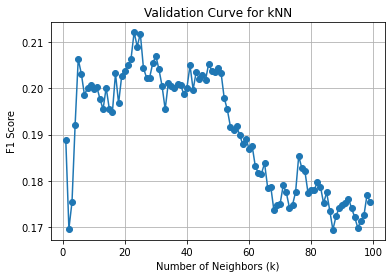

In [16]:
import matplotlib.pyplot as plt

# Plot the validation curve for F1 score vs. number of neighbors
plt.plot(grid_search.cv_results_['param_n_neighbors'].data.astype(int), grid_search.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('Validation Curve for kNN')
plt.grid(True)
plt.show()

In [17]:
# Initialize and train K-Nearest Neighbors Classifier with the best number of neighbors found
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_scaled, y)

# Prepare and scale the test data similarly
test_data_transformed = scaler.transform(test_data[feature_columns])

# Making predictions
test_predictions = model.predict(test_data_transformed)

# Converting predictions back to original labels
test_predictions_labels = label_encoders['Education'].inverse_transform(test_predictions)

# Preparing the dataframe for submission
submission_df = pd.DataFrame({'ID': test_data['ID'], 'Predicted Education': test_predictions_labels})

# Exporting to CSV
submission_df.to_csv('predicted_education.csv', index=False)


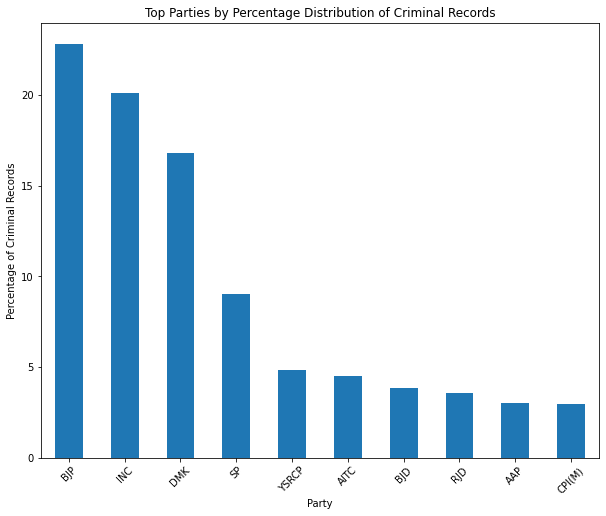

In [19]:
# Decoding the Party
train_data['Party'] = label_encoders['Party'].inverse_transform(train_data['Party'])
# Group data by 'Party' and sum 'Criminal Case' for each party
party_crime = train_data.groupby('Party')['Criminal Case'].sum().sort_values(ascending=False)

# Calculate percentage distribution
party_crime_percent = (party_crime / party_crime.sum()) * 100

# Plot
plt.figure(figsize=(10, 8))
party_crime_percent.head(10).plot(kind='bar')  # Adjust to show more or fewer parties
plt.title('Top Parties by Percentage Distribution of Criminal Records')
plt.xlabel('Party')
plt.ylabel('Percentage of Criminal Records')
plt.xticks(rotation=45)
plt.show()


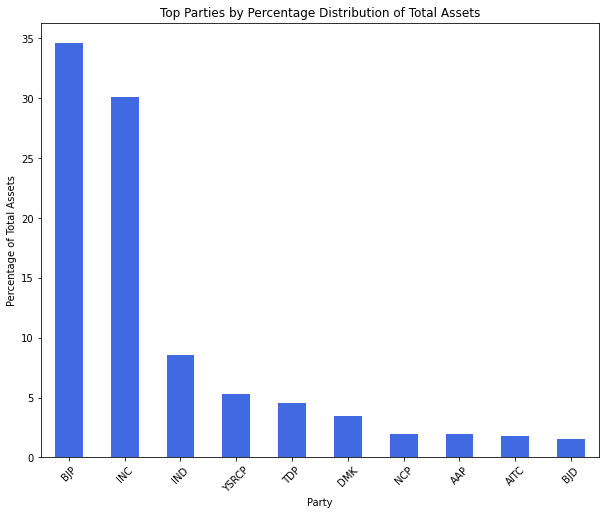

In [20]:
# Group data by 'Party' and sum 'Total Assets' for each party
party_wealth = train_data.groupby('Party')['Total Assets'].sum().sort_values(ascending=False)

# Calculate percentage distribution
party_wealth_percent = (party_wealth / party_wealth.sum()) * 100

# Plot
plt.figure(figsize=(10, 8))
party_wealth_percent.head(10).plot(kind='bar', color='royalblue')  # Adjust to show more or fewer parties
plt.title('Top Parties by Percentage Distribution of Total Assets')
plt.xlabel('Party')
plt.ylabel('Percentage of Total Assets')
plt.xticks(rotation=45)
plt.show()
